# Working notes

Working notes
* Site: https://www.soa.org/resources/experience-studies/2017/2009-13-indiv-life-ins-mort-exp/
* Appendices: https://www.soa.org/globalassets/assets/files/research/exp-study/2009-13-indiv-life-ins-mort-exp-appendix.xlsx

Note: the zip of the csv is also at the site.

This work is based off duplicating appendix G.  My old data selection did not quite duplicate appendix G.  The totals in the published appendix across products do not match the rows, so I'm not going to sweat duplicating that here.

## Description of use

Run the notebook to initialize the libraries and generate exhibits.

Results differer slightly from the published report, due largely to differences between the published and earlier ILEC datasets.

# Initialize libraries

In [324]:
import os
import sys
import re
import pandas as pd
import numpy as np
from pathlib import Path

# In case you haven't installed ILECTools, this bit will get the ilectools directory into 
# your search path to its functions can be imported.

dir_home = str(Path.home())
if not any([Path(_p).name=='ILECTools' for _p in sys.path]):
    sys.path.append(dir_home + '/dev/ILECTools') # is where it is on this machine


import ilectools
ilectools = reload(ilectools)
from ilectools import glmtools
glmtools = reload(glmtools)
from ilectools.glmtools import PoissonWrapper


%config Completer.use_jedi=False # helps with autocompleter in notebook in some configurations
pd.options.display.float_format = '{:,.0f}'.format
pd.options.display.width=255
pd.options.display.max_rows = 100

# Fields aggregated here, value columns
valcols = ['policy_actual', 'policy_2015vbt', 'amount_actual', 'amount_2015vbt']    

# variables used in the model
exogvars = 'uw,face_amount_band,observation_year,dur_band1,ia_band1,gender,insurance_plan,ltp,iy_band1'.split(',')

# Initialize data

The data must be preprocessed in advance.

In [231]:
%%time
data = glmtools.append_columns_for_model(
    pd.read_parquet(dir_home + '/data/ilec/Data/Processed/2021_published/ILEC 2009-18 20210528_v2.parquet')
    )

# There happen to be some records with no exposure, they also have no tabular expecteds, and will hurt
# when the log of the tabular expecteds are taken later.
data = data[(data.amount_exposure>0) & (data.policy_exposure>0)]

# subset of data for exhibit g, the example used in 
data_exhibit_g = glmtools.exhibit_g_subset(data)

del data # why not free up a few gb of RAM
# tidiness
import gc
gc.collect()

In [349]:
# model will run better on a summary - or: will run at all
data_exhibit_g_summary = data_exhibit_g.pivot_table(index=exogvars, values=valcols, aggfunc=np.sum).reset_index()

# Models

In [351]:
%%time
ilectools = reload(ilectools)
glmtools = reload(glmtools)
# get policy and amount models
models = {
    m:glmtools.PoissonWrapper(
        offset_column=f'{m}_2015vbt'
      , formula = f"""{m}_actual ~
                + C(uw, Treatment(reference='N/2/1'))
                + C(dur_band1, Treatment(reference='06-10'))
                + C(face_amount_band, Treatment(reference='  100000-249999'))
                + C(ia_band1, Treatment(reference='40-44'))
                + C(gender)
                + C(observation_year)
                + C(insurance_plan, Treatment(reference='Term'))
                + C(ltp, Treatment(reference='20 yr or N/A (Not Term)'))
                + C(iy_band1)
            """
      , data = data_exhibit_g_summary
    )
    
    for m
    in ['policy', 'amount']
}


Optimization terminated successfully.
         Current function value: 0.395291
         Iterations 6
Optimization terminated successfully.
         Current function value: 93580.917352
         Iterations 6
CPU times: user 1min 20s, sys: 38 s, total: 1min 58s
Wall time: 26.4 s


In [355]:
for model_item in ['policy', 'amount']:
    data_exhibit_g_summary[f'{model_item}_{model_item}model'] = models[model_item].fit.predict()
# adjust each 2015vbt tabular amount (policy or amount) by the model factor from modelling the other one:
data_exhibit_g_summary['policy_amountmodel'] = (data_exhibit_g_summary['amount_amountmodel'] / data_exhibit_g_summary['amount_2015vbt']
                                                * data_exhibit_g_summary['policy_2015vbt'])
data_exhibit_g_summary['amount_policymodel'] = (data_exhibit_g_summary['policy_policymodel'] / data_exhibit_g_summary['policy_2015vbt']
                                                * data_exhibit_g_summary['amount_2015vbt'])

Using factors for the amount model will duplicate the total amount, using factors for the policy model will return a bit different amount in total, and vice versa for the policy count model:

In [356]:
data_exhibit_g_summary.filter(regex='(model|actual)$').sum().sort_index()

amount_actual        82,334,814,776
amount_amountmodel   82,334,814,776
amount_policymodel   82,947,445,771
policy_actual               623,265
policy_amountmodel          617,185
policy_policymodel          623,265
dtype: float64

# Appendix 1

In [367]:
glmtools = reload(glmtools)

In [368]:
glmtools.get_exhibit_g(data_exhibit_g_summary, 'policy', '2015vbt',
                       "Table 2a: Exhibit G Actual / qx2015vbt by Count; by Plan and Duration")

In [326]:
m = models['policy']

In [327]:
jnk = m.factor_analysis_exhibit('insurance_plan')
jnk.style.format('{:,.2f}').set_table_styles(
    [{'selector': 'th', 'props': [('border-style','solid'),
                                  ('border-width','1px')]},
     {'selector': 'td', 'props': [('border-style','dashed'),
                                  ('border-width','1px')]},
    ])

In [328]:
m.fit.model.data.frame.pivot_table(index='insurance_plan', columns='uw', values=m.offset_column, aggfunc=np.sum)\
    .apply(lambda s: s/s.sum()).style.format('{:,.1%}')

uw,N/1/1,N/2/1,N/2/2,N/3/1,N/3/2,N/3/3,N/4/1,N/4/2,N/4/3,N/4/4,S/1/1,S/2/1,S/2/2,U/1/1
insurance_plan,,,,,,,,,,,,,,
Other,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%
Perm,55.1%,18.3%,34.3%,3.3%,4.2%,6.4%,0.1%,0.2%,0.1%,0.7%,63.3%,12.7%,16.6%,87.8%
Term,7.1%,22.8%,21.7%,76.2%,58.7%,48.8%,92.6%,90.2%,88.5%,81.1%,6.6%,56.1%,38.0%,1.1%
UL,29.8%,32.0%,26.3%,7.5%,12.3%,17.5%,0.5%,0.8%,1.5%,4.5%,22.3%,13.9%,23.1%,10.1%
ULSG,1.6%,10.5%,6.4%,9.6%,20.7%,23.2%,5.6%,8.0%,8.1%,12.0%,0.8%,8.8%,10.7%,0.0%
VL,5.4%,13.2%,8.7%,2.1%,2.8%,3.0%,0.3%,0.2%,0.4%,1.1%,5.9%,6.0%,8.3%,0.8%
VLSG,1.0%,3.3%,2.5%,1.2%,1.3%,1.2%,0.8%,0.7%,1.4%,0.7%,1.2%,2.5%,3.3%,0.1%


In [329]:
p = m.plot_comparision()

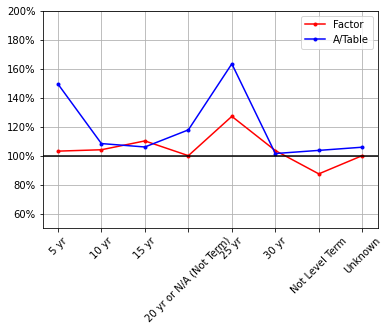

In [330]:
p['ltp']

In [331]:
m.compare_factors_with_a_to_t().style.format('{:,.1%}')

## Exhibit 3a

In [267]:
# model is by policy
# scale to get amount model?
m.fit.model.data.frame['policy_model'] = m.fit.predict()
m.fit.model.data.frame['amount_model'] = m.fit.model.data.frame['policy_model'] / m.fit.model.data.frame['policy_2015vbt'] * m.fit.model.data.frame['amount_2015vbt']

In [261]:
get_exhibit_g(m.fit.model.data.frame, 'policy')

In [262]:
get_exhibit_g(m.fit.model.data.frame, 'amount', '2015vbt')

In [263]:
get_exhibit_g(m.fit.model.data.frame, 'amount', 'model')

# Appendix 2

In [269]:
m.factorAnalysisExhibit('insurance_plan')

AttributeError: 'builtin_function_or_method' object has no attribute 'name'

# Now finish the exhibits

In [ ]:
def factorAnalysisExhibit(self, forEach):
    """Show across categories in forEach: 

    A/Table
    Factor
    Average of all other factors
    Approximate A/Table (product of all factors or average thereof) 

   arguments:
       forEach: should be a category in the model

   ... Compare factors for a split with the average factor in the applicable other categories and a/table"""
    cf = {_df.index.names[0]:_df
          for _df 
          in self.compareFactorsAE()}[forEach].T
    cfa = self.compFactorAvg(forEach) # the average factor: must exclude category forEach from this becasue is shown
             # as factor already
    # Show intercept (overall factor) and take out the one that we're splitting by since we show it already
    cfa = pd.concat([
        pd.DataFrame(self.fit.model.family.link.inverse(self.prettyParams()[('Intercept', 'Intercept')])
                         , index=['Overall']
                     , columns=cfa.columns)
        , cfa.loc[cfa.index!= forEach]], axis=0            
        )
    # datafame of a/t and the estimate
    atdf = pd.DataFrame({'Observed':cf.loc['A/Table']
                         , 'Approximated':cfa.product(axis=0) * cf.loc['Factor']})[
                        ['Observed','Approximated'] # to reorder
                    ].T
    res = pd.concat([atdf # The A/T that we'd like to explain
                     , pd.DataFrame({forEach:cf.loc['Factor']}).T # the factors themselves
                     , cfa
                     ]
                     , keys=['A/VBT15', 'Factor','Avg factors']) # The overall factor (intercept) will show as avg, is OK
    res.index.names = ['',''] # so don't show "None","None" when writing out
    return res

m = models['amount']
factorAnalysisExhibit(m, 'insurance_plan')

In [110]:
jnk = m.fit.summary().tables[1]

In [118]:
m.fit.summary2().tables[1]

,Coef.,Std.Err.,z,P>|z|,[0.025,0.975]
Intercept,-0,0,"-2,154",0,-0,-0
"C(uw, Treatment(reference='N/2/1'))[T.N/1/1]",0,0,"6,853",0,0,0
"C(uw, Treatment(reference='N/2/1'))[T.N/2/2]",0,0,"23,703",0,0,0
"C(uw, Treatment(reference='N/2/1'))[T.N/3/1]",-0,0,"-9,540",0,-0,-0
"C(uw, Treatment(reference='N/2/1'))[T.N/3/2]",-0,0,"-1,743",0,-0,-0
...,...,...,...,...,...,...
"C(ltp, Treatment(reference='20 yr or N/A (Not Term)'))[T.Not Level Term]",-0,0,"-3,348",0,-0,-0
"C(ltp, Treatment(reference='20 yr or N/A (Not Term)'))[T.Unknown]",0,0,"1,464",0,0,0
C(iy_band1)[T.1990-1999],0,0,426,0,0,0
C(iy_band1)[T.2000-2009],-0,0,"-1,294",0,-0,-0


In [78]:
m = models['amount']

#jnk = {_.index.names[0]:_ for _ in compareFactorsAE(m)}#.style.format('{:,.2%}')
#jnk['insurance_plan'].style.format('{:,.2%}')
#m.factorAnalysisExhibit('insurance_plan')


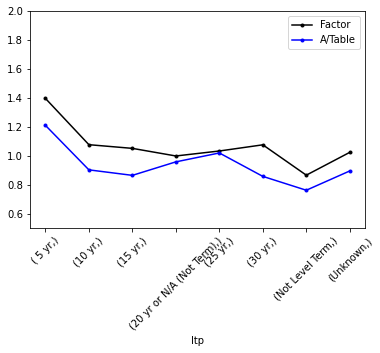

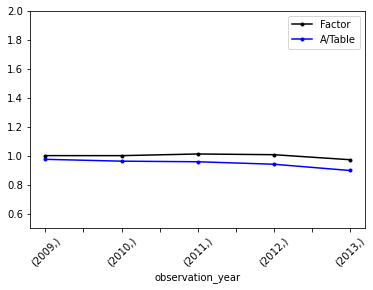

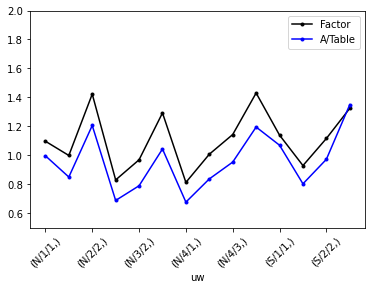

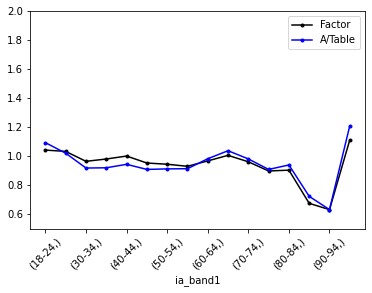

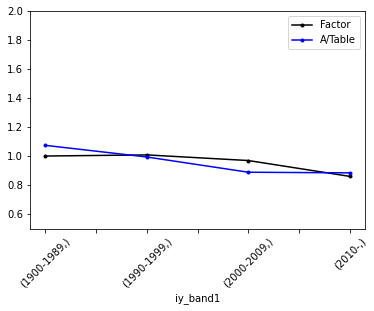

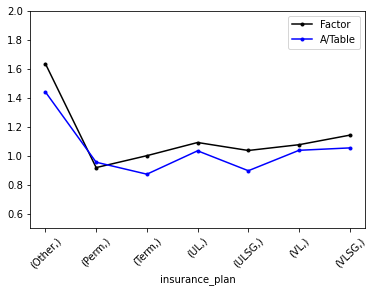

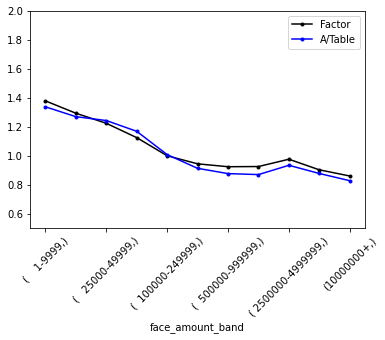

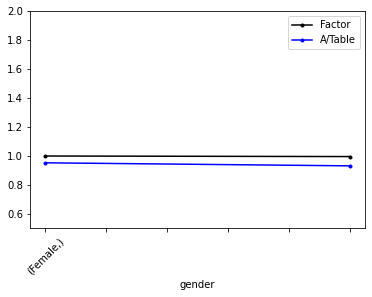

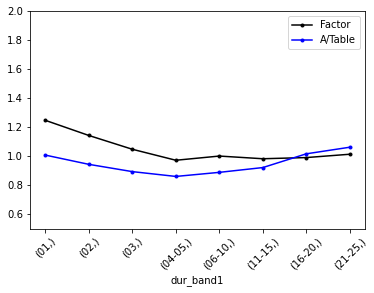

In [79]:
m.compareFactorsAEPlot();

<AxesSubplot:>

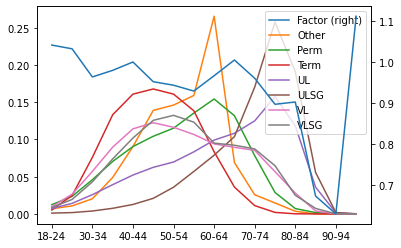

In [80]:
m.compFactorDist('ia_band1', 'insurance_plan').plot(secondary_y='Factor')

In [81]:
m.compFactorAvg('insurance_plan').style.format('{:,.1%}')

,Other,Perm,Term,UL,ULSG,VL,VLSG
insurance_plan,163.4%,91.8%,100.0%,109.1%,103.6%,107.6%,114.2%
iy_band1,94.3%,99.8%,96.9%,98.8%,96.6%,99.1%,97.6%
dur_band1,104.6%,100.3%,100.6%,99.9%,100.4%,99.2%,99.6%
gender,99.7%,99.7%,99.7%,99.8%,99.8%,99.7%,99.7%
ia_band1,96.1%,96.5%,96.5%,93.8%,92.0%,96.1%,95.8%
ltp,100.0%,100.0%,102.6%,100.0%,100.0%,100.0%,100.0%
uw,110.7%,113.2%,103.3%,113.1%,113.1%,113.2%,112.2%
face_amount_band,91.6%,102.7%,94.6%,97.6%,93.1%,97.3%,95.5%
observation_year,99.0%,99.8%,99.6%,99.7%,99.5%,99.7%,99.7%


In [82]:
m.factorAnalysisExhibit('insurance_plan')

KeyError: 'insurance_plan'

In [ ]:
pd.DataFrame(dict(x=np.exp(m.prettyParams()['insurance_plan']))).style.format('{:,.1%}')

In [ ]:
cf = m.compareFactorsAE()

In [ ]:
import networkx as nx
import itertools
from functools import reduce


from ilectools.glmtools import results_summary_to_dataframe, getKV
from ilectools import glmtools

In [38]:
coefOrig = m.getCoef()

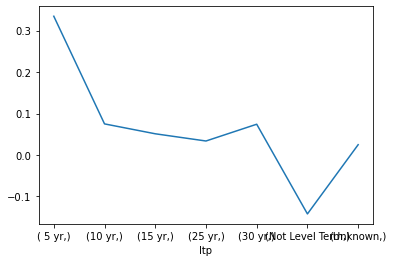

In [39]:
df = coefOrig[0]
df.plot();


<AxesSubplot:xlabel='ltp'>

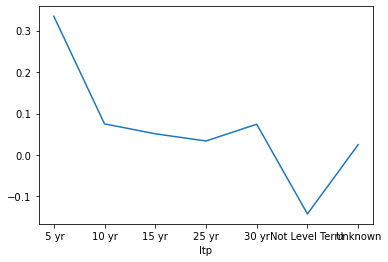

In [40]:

def multiindex_to_index(df):
    if df.index.ndim==1:
        df.index = pd.Index([i[0] for i in df.index], name=df.index.names[0])
multiindex_to_index(df)
df.plot()


In [ ]:
coefOrig[0].index.to_flat_index

In [ ]:
pd.options.display.float_format = '{:,.4e}'.format
coefOrig[2]

In [ ]:
import ilectools

In [ ]:
list(list(ilectools.glmtools.getSubgraphs(coefOrig))[0])

In [ ]:
m.compareFactorsAE()

In [ ]:
m.showFactorsVsTableBetweenCatgories(plot=False)

In [ ]:
from statsmodels.formula.api import poisson

In [ ]:
import statsmodels.formula.api as smf

In [ ]:
tmp = smf.poisson(m.fit.model.formula, m.fit.model.data.frame, offset=m.fit.model.offset)

In [ ]:
tmpf = tmp.fit()

In [ ]:
m.fit.summary()

In [ ]:
tmpf.summary()

In [ ]:
tm


In [ ]:
m.fit.model?

In [ ]:
poisson

# End